# <center> Replication of Arifovic and Ledyard (2012 JPUBE) </center>
### <center> Code by Yaroslav Rosokha </center>

In [25]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
import time

In [26]:
def payoffs(C,m=.3,p=1,w=10): 
    '''
    C -- matrix of contribution proportions (number of groups)x(number of players per group)
    m -- marginal product of public good (varied in the paper)
    w -- endowment (set to 10)
    p -- marginal willingness to pay (set constant 1 across all subjects)
    
    returns matrix of payoffs of the same shape as C
    '''
    n_groups,n_players = C.shape
    Y=m*w*C.sum(axis=1).repeat(n_players).reshape((n_groups,n_players))
    
    return p*w*(1-C)+Y #notice that strategies in C are normalized to be between 0 and 1 so multiplied by w

In [27]:
def utility(C,BETA=0,GAMMA=0,m=.3):
    ''' 
    C -- matrix of contribution proportions (number of groups)x(number of players per group)
    m -- marginal product of public good (varied in the paper)
    BETA -- matrix of individual betas (if all are the same then can use one number)
    GAMMA -- matrix of individual gammas (if all are the same then can use one number)
    '''
    
    n_groups,n_players = C.shape
    P = payoffs(C,m=m)
    AVERAGE = P.mean(axis=1).repeat(n_players).reshape((n_groups,n_players))
    return P+BETA*AVERAGE-GAMMA*np.maximum(0,AVERAGE-P)

In [28]:
def counter_factual(matching,c,A,betas,gammas,m=.3): 
    '''
    matching -- matrix of indices. each row corresponds to a game.
    c -- contributions by players vector with 1 entry for each player.
    m -- marginal product of public good (varied in the paper)
    A -- set of normalized strategies with number of rows equal to number of players in the population and number of columns equal to number of strategies
    '''
    
    n_groups,n_players = matching.shape # shape - attribute of any numpy array (gives its dimension)
    strategies_in_set = A.shape[1]
    out = np.zeros_like(A)
    
    #Go through every column of the matching matrix
    for i in range(n_players):    
        others = np.delete(matching,i,axis=1) #get index ids of other players that you are matched with
        repeated_others = np.repeat(others,strategies_in_set,axis=0) #repeat so that can merge with J strategies in the set
        n_entries=repeated_others.shape[0]
        players = matching[:,i]
        repeated_players = np.repeat(players,strategies_in_set,axis=0).reshape((n_entries,1))
        repeated_all = np.hstack((repeated_players,repeated_others))

        ci= A[players,:].reshape((n_entries,1))
        C = np.hstack((ci,c[repeated_others]))
        B = betas[repeated_all]
        G = gammas[repeated_all]

        out[players,:] = utility(C,B,G,m)[:,0].reshape((n_groups,strategies_in_set)) #<- first column is the relevant one      
    
    return out

In [29]:
class population():
    
    def __init__(self,m=.3,w=10,session_size=10000,players_per_game=4,strategies_in_set=100):
        ''' 
        m -- marginal product of public good (varied in the paper)
        session_size -- number of agents
        strategies_in_set -- number of strategies for each agent (in paper it is J=100)
        '''
        
        #VCM parameters
        self.m=m
        self.w=w
        
        #Session and game sizes (i.e., number of agents and how they are divided into games)
        self.session_size=session_size
        self.players_per_game=players_per_game
        self.simulteneous_games = int(session_size / players_per_game)
        self.matching = np.arange(session_size).reshape(self.simulteneous_games,self.players_per_game)
        
        #initialize all players and their strategies
        self.j = strategies_in_set
        self.A = np.random.uniform(size=(session_size,strategies_in_set)) # (n players, n strategies for each player)
        self.V = np.zeros_like(self.A) #initialize values associated with strategies to 0
        self.c = self.A[:,0].copy() #<-- since initial actions are random just pick the first element in A_i for each player
        
        #initialize population of preferences
        selfish = np.random.binomial(1,1-.48,size=self.session_size)
        self.betas = 22*np.random.uniform(size=self.session_size)*selfish
        self.gammas = 8*np.random.uniform(size=self.session_size)*selfish
        
    def experimentation(self):
        select=np.random.binomial(1,.033,size=(self.session_size,self.j))
        mut=np.random.randn(self.session_size,self.j)*.1
        self.A+=select*mut
        self.A=np.minimum(np.maximum(self.A,0),1)
        
    def replication(self):
        self.V = counter_factual(self.matching,self.c,self.A,self.betas,self.gammas,m=self.m)
        for i in range(self.session_size):
            pick1=np.random.randint(self.j,size=self.j)
            pick2=np.random.randint(self.j,size=self.j)
            select = (self.V[i,pick1]>=self.V[i,pick2])*1
            self.A[i] = self.A[i,pick1]*select+self.A[i,pick2]*(1-select)
            self.V[i] = self.V[i,pick1]*select+self.V[i,pick2]*(1-select)
            
    def selection(self):
        for i in range(self.session_size):
            norm=self.V[i]-self.V[i].min()
            if norm.sum()>0:
                prob = norm/norm.sum()
            else:
                prob = np.ones_like(norm)/self.j
            self.c[i] = np.random.choice(self.A[i],size=1,p=prob)
            
    def supergame(self,T):
        #create new matching for the supergame
        flat_matching = self.matching.flatten()
        np.random.shuffle(flat_matching)
        self.matching = flat_matching.reshape(self.simulteneous_games,self.players_per_game)
        
        self.average_contribution = np.zeros(T)
        for t in range(T):
            self.selection()
            self.average_contribution[t]=self.w*self.c.mean()
            self.experimentation()
            self.replication()
            
        return self.average_contribution

Took 82.5 seconds to run


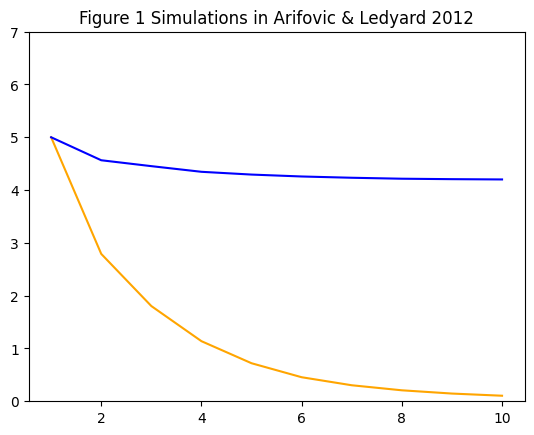

In [30]:
start_t=time.time()
n_rounds = 10
pop1 = population(m=.3,players_per_game=4)
treat1 = pop1.supergame(n_rounds)
pop2 = population(m=.75,players_per_game=4)
treat2 = pop2.supergame(n_rounds)
end_t = time.time()
print("Took {:.1f} seconds to run".format(end_t-start_t))

plt.plot(np.arange(1,n_rounds+1),treat1,'orange')
plt.plot(np.arange(1,n_rounds+1),treat2,'blue')
plt.ylim(0,7)
plt.title("Figure 1 Simulations in Arifovic & Ledyard 2012")
plt.show()

Took 79.8 seconds to run


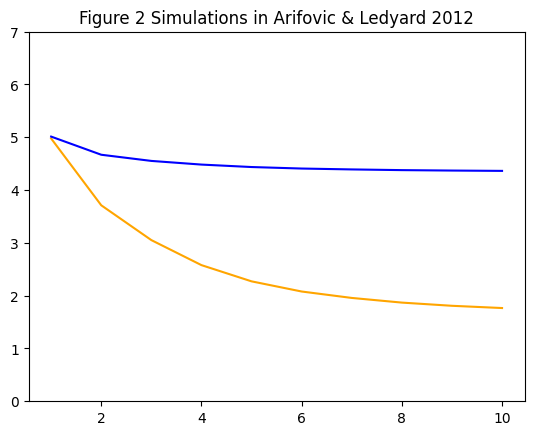

In [31]:
start_t=time.time()
n_rounds = 10
pop1 = population(m=.3,players_per_game=10)
treat1 = pop1.supergame(n_rounds)
pop2 = population(m=.75,players_per_game=10)
treat2 = pop2.supergame(n_rounds)
end_t = time.time()
print("Took {:.1f} seconds to run".format(end_t-start_t))

plt.plot(np.arange(1,n_rounds+1),treat1,'orange')
plt.plot(np.arange(1,n_rounds+1),treat2,'blue')
plt.ylim(0,7)
plt.title("Figure 2 Simulations in Arifovic & Ledyard 2012")
plt.show()